In [1]:
# The purpose of this notebook is to determine what minimum non-def rate to use as a cutoff
# as well as determine which top% of remaining and how exactly to choose?
# e.g. something like, prob of not def >= 95% and then of those passing, choose top 5%?
# Or should I also choose a hard cutoff with the regr as well?
# Those investigations are in this notebook

In [491]:
import sys
sys.path

['/home/justin/projects/lendingclub/notebooks/modeling',
 '/home/justin/anaconda3/envs/lendingclub/lib/python37.zip',
 '/home/justin/anaconda3/envs/lendingclub/lib/python3.7',
 '/home/justin/anaconda3/envs/lendingclub/lib/python3.7/lib-dynload',
 '',
 '/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages',
 '/home/justin/projects/j_utils',
 '/home/justin/projects/lendingclub',
 '/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/IPython/extensions',
 '/home/justin/.ipython']

In [356]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# from pandas.testing import assert_frame_equal
from catboost import CatBoostClassifier, CatBoostRegressor
from joblib import load
import pickle
from tqdm.notebook import tqdm

import j_utils.munging as mg
from lendingclub import config
from lendingclub.modeling.models import Model

pd.set_option('max_columns', 999)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

ppath = config.prj_dir
dpath = config.data_dir
cols = ['roi_simple', 'grade', 'loan_status', '0.07', 'catboost_both_score', 'catboost_regr', 'catboost_clf']
plot_cols = cols + ['pctl_clf', 'pctl_regr', ]#'catboost_both_slow'

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [8]:
all_scores = pd.read_feather(os.path.join(config.data_dir, 'eval_loan_info_scored.fth'))
base_loan_info = pd.read_feather(os.path.join(config.data_dir, 'base_loan_info.fth'))
with open(os.path.join(config.data_dir, 'train_test_ids.pkl'), 'rb') as f:
    train_test_ids = pickle.load(f)
test_ids = train_test_ids['test']
done_ids = train_test_ids['train_testable']
print(all_scores.shape, base_loan_info.shape)

# TEMPORARY - ADD INTEREST RATE TO EVAL_LOAN_INFO/ALL_SCORES
all_scores['int_rate'] = base_loan_info['int_rate']

(2507335, 48) (2507335, 90)


In [56]:
# add in clf and regr scores
both = Model('catboost_both')
combo_scores = both.score(base_loan_info.copy(), return_all=True, random_penalty=True)
all_scores['catboost_both_rand'] = combo_scores[0]
all_scores['catboost_regr'] = combo_scores[1]
all_scores['catboost_clf'] = combo_scores[2]
all_scores['catboost_regr_scl'] = (all_scores['catboost_regr'] - all_scores['catboost_regr'].min())/(all_scores['catboost_regr'].max() - all_scores['catboost_regr'].min())

all_scores['pctl_clf'] = pd.qcut(all_scores.catboost_clf, 100, labels=False)
all_scores['pctl_regr'] = pd.qcut(all_scores.catboost_regr, 100, labels=False)
# all_scores['pctl_both'] = pd.qcut(all_scores.catboost_both_score, 100, labels=False)
all_scores['pctl_both_rand'] = pd.qcut(all_scores.catboost_both_rand, 100, labels=False)
# add months recorded 
all_scores['months_recorded'] = ((all_scores['end_d'] - all_scores['issue_d'])/np.timedelta64(1, 'M')).round()

# split train_testable
done_all_scores = all_scores.query('id in @done_ids')
# done_base_loan_info = base_loan_info.query('id in @done_ids')

# split old enough
old_done_scores = done_all_scores.query('maturity_time >= .95')

# split testable
test_scores = all_scores.query('id in @test_ids')
# test_base_loan_info = base_loan_info[base_loan_info['id'].isin(test_ids)]

# Verify that ending important distributions of test and all are the same

In [10]:
print(all_scores.shape, old_done_scores.shape, test_scores.shape)
all_scores_36 = all_scores.query('term == 36')
old_done_scores_36 = old_done_scores.query('term == 36')
test_scores_36 = test_scores.query('term == 36')
print(all_scores_36.shape, old_done_scores_36.shape, test_scores_36.shape)

(2507335, 56) (1018290, 56) (156431, 56)
(1776471, 56) (890022, 56) (117806, 56)


<IPython.core.display.Javascript object>


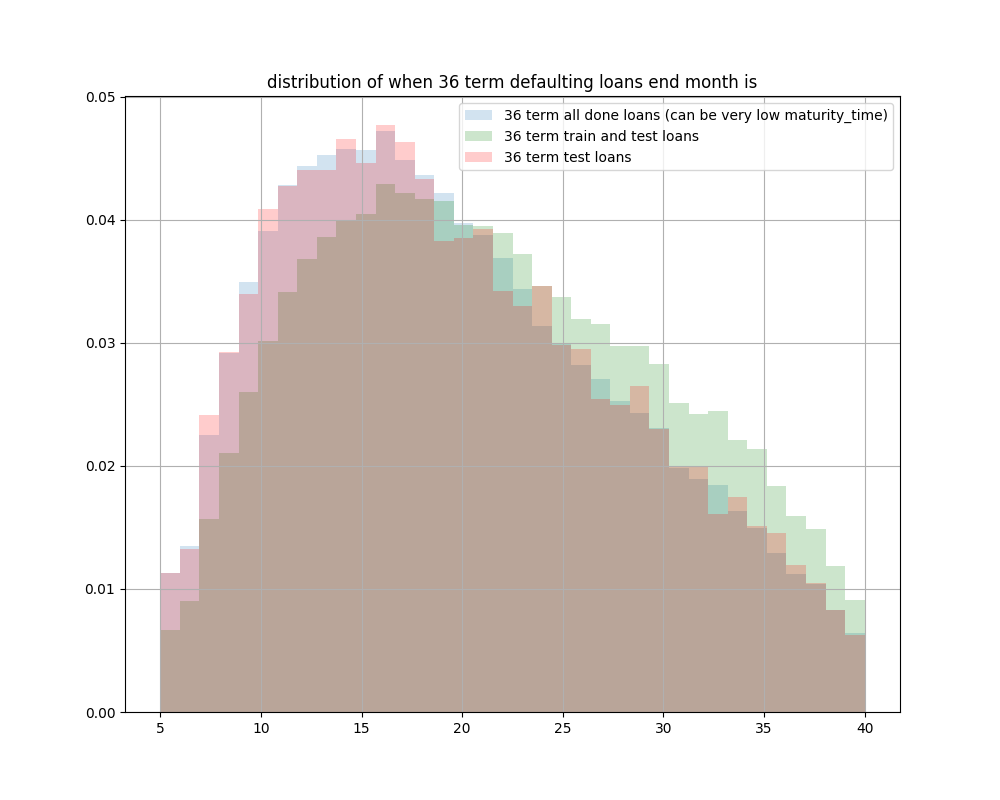

In [11]:
# distributions to check are between I expect months_recorded distribution to be same
# between old_done_scores_36 and test_scores_36 but not all_done_scores_36 (more early
# defaulting loans that have low maturity_time)
plt.figure(figsize=(10,8))
plt.title('distribution of when 36 term defaulting loans end month is')
def_query = 'term == 36 and months_recorded <= 40 and months_recorded >= 5 and loan_status in ["defaulted", "charged_off"]'
paid_query = 'term == 36 and months_recorded <= 36 and months_recorded >= 1 and loan_status == "paid"'
all_scores_36.query(def_query).months_recorded.hist(bins=36, density=True, alpha=.2, label='36 term all done loans (can be very low maturity_time)')

old_done_scores_36.query(def_query).months_recorded.hist(bins=36, density=True, alpha=.2, label='36 term train and test loans', color='green')

test_scores_36.query(def_query).months_recorded.hist(bins=36, density=True, alpha=.2, label='36 term test loans', color='red')
plt.legend()

# The test ids are from 2010-1-1 onward, and we see that these loans tend to default earlier compared to train and test (green vs orange). We see also that blue which is all done loans also looks much more similar test (blue vs green)

<IPython.core.display.Javascript object>


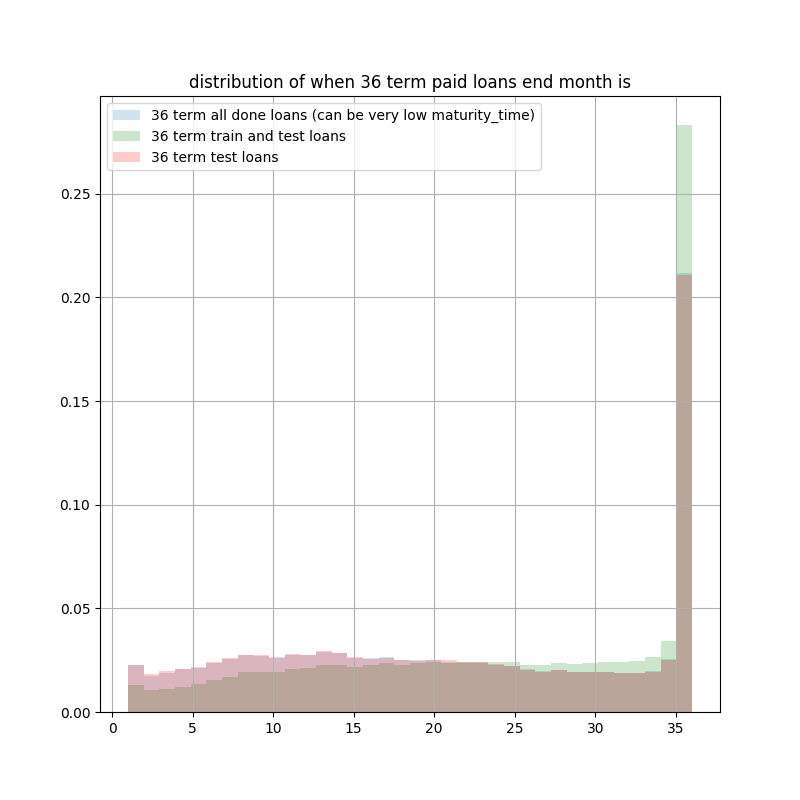

In [12]:
plt.figure(figsize=(8,8))
plt.title('distribution of when 36 term paid loans end month is')
all_scores_36.query(paid_query).months_recorded.hist(bins=36, density=True, alpha=.2, label='36 term all done loans (can be very low maturity_time)')

old_done_scores_36.query(paid_query).months_recorded.hist(bins=36, density=True, alpha=.2, label='36 term train and test loans', color='green')

test_scores_36.query(paid_query).months_recorded.hist(bins=36, density=True, alpha=.2, label='36 term test loans', color='red')
plt.legend()

# The test ids are from 2010-1-1 onward, and we see that these loans tend to default earlier compared to train and test (green vs orange). We see also that blue which is all done loans also looks much more similar test (blue vs green)

In [13]:
# the test loans are more like the distributions I will be seeing now, so 
# all the probabilistic stuff should use the test_loan distribution

# check score distributions and normalized distributions
# work with scaled regr_score so that it lies between 0-1
# and can be linearly combined with clf_score (prob of default btwn 0-1)

<IPython.core.display.Javascript object>


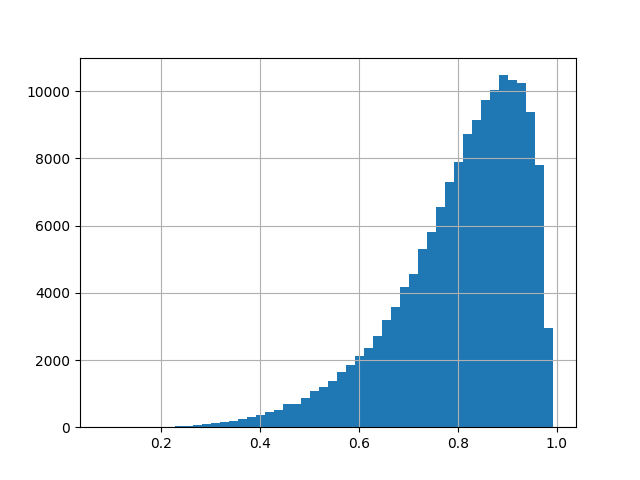

In [14]:
fig = plt.figure()
test_scores['catboost_clf'].hist(bins=50)
plt.show()

Scaling - Max: 0.3253468660329166 Min: -1.0514865667720885


<IPython.core.display.Javascript object>


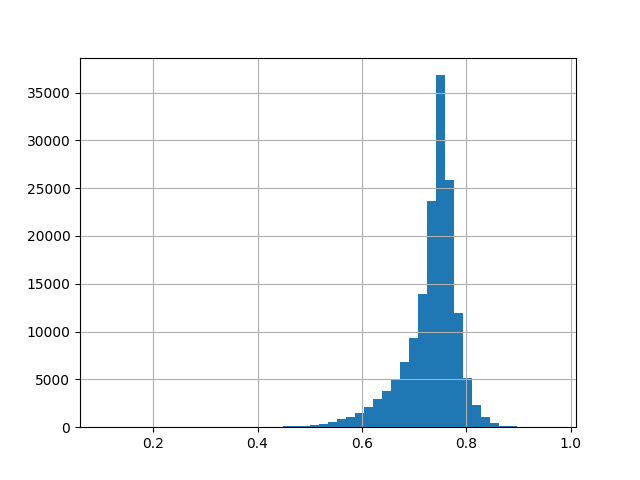

Scaled all - Max: 1.0 Min:0.0
Scaled test - Max: 0.9666427412637907 Min:0.1032734163769524


In [15]:
print('Scaling - Max: {0} Min: {1}'.format(all_scores['catboost_regr'].max(),all_scores['catboost_regr'].min()))
fig = plt.figure()
test_scores['catboost_regr_scl'].hist(bins=50)
plt.show()
print('Scaled all - Max: {0} Min:{1}'.format(all_scores['catboost_regr_scl'].max(), all_scores['catboost_regr_scl'].min()))
print('Scaled test - Max: {0} Min:{1}'.format(test_scores['catboost_regr_scl'].max(), test_scores['catboost_regr_scl'].min()))

In [16]:
# fig = plt.figure()
# test_scores['catboost_regr'].hist(bins=50)
# plt.show()

# Interpolated score versions

## Linear

In [17]:
def pctl_interp_score(df, clf_weight, clf_score_name, regr_score_name, interp_type = 'linear'):
    '''
    given clf scores, regr scores, and clf_weight, return roi of percentiles
    '''
    assert 'catboost_regr' in df
    assert 'catboost_clf' in df
    if interp_type == 'linear':
        df['catboost_interp_'+interp_type] = df[clf_score_name]*clf_weight + \
                                    df[regr_score_name]*(1-clf_weight)
        df['pctl_ctb_interp_'+interp_type] = pd.qcut(df['catboost_interp_'+interp_type], 100, labels=False, duplicates='drop')
    else:
        pass
    roi_mean = {}
    def_mean = {}
    for pctl, group in df.groupby('pctl_ctb_interp_'+interp_type):
        roi_mean[pctl] = group['roi_simple'].mean()
        def_mean[pctl] = group['target_loose'].mean()
    return pd.Series(roi_mean), pd.Series(def_mean)

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


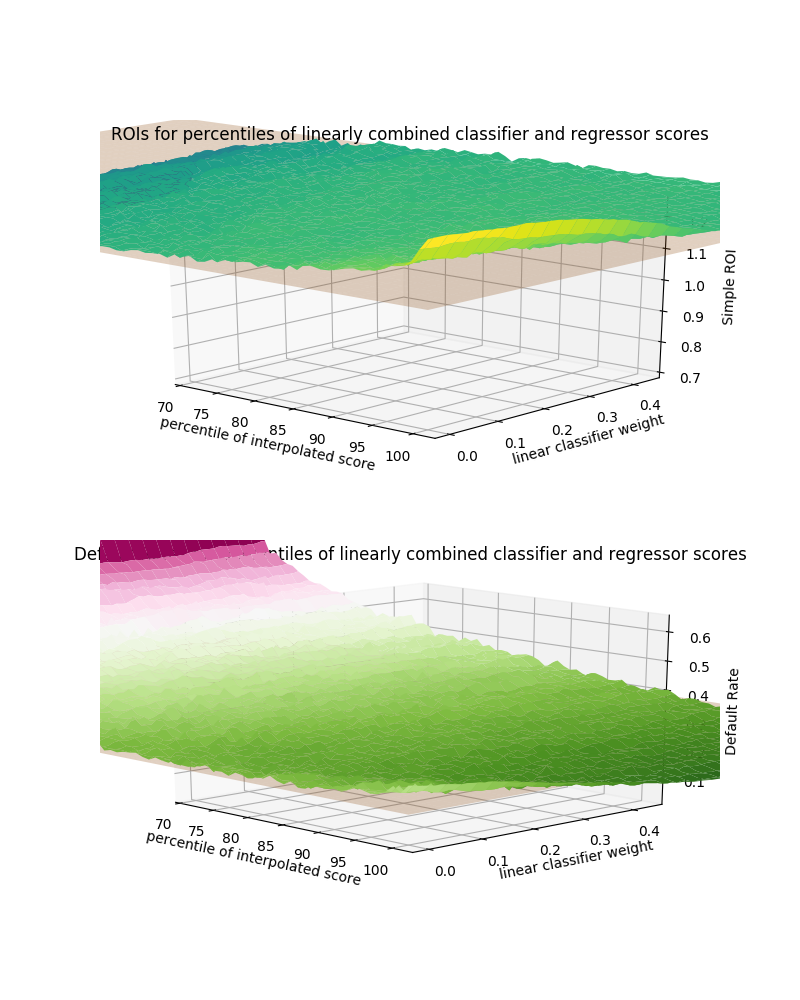

(70, 102)

In [18]:
# 3 dimensions, Z = roi, x/y = pctl vs weight
clf_w = 1-np.arange(0,1.01, .01)
# make x/y/z, start with full clf and end with full regr
lin_ret_dict = {}
lin_def_dict = {}
# generate the scores
for w in clf_w:
    lin_ret_dict[w], lin_def_dict[w] = pctl_interp_score(test_scores, w, 'catboost_clf', 'catboost_regr')
    
# some constants
desired_sROI = 1.05
desired_def = .1

lin_ret_df_3d = pd.DataFrame(lin_ret_dict)
lin_def_df_3d = pd.DataFrame(lin_def_dict)
x = lin_ret_df_3d.index.values+1
x = np.tile(x,(len(clf_w),1))
y = lin_ret_df_3d.columns.values
y = np.tile(y, (100, 1)).T
z_ret_unscaled = lin_ret_df_3d.values.T
z_def_unscaled = lin_def_df_3d.values.T
# plot
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(2,1,1,projection='3d')
ax.plot_surface(x, y, z_ret_unscaled, cmap='viridis', edgecolor='none')
ax.plot_surface(x, y, np.ones(x.shape)*desired_sROI, alpha = .25)
ax.set_title('ROIs for percentiles of linearly combined classifier and regressor scores')
ax.set_xlabel('percentile of interpolated score')
ax.set_ylabel('linear classifier weight')
ax.set_zlabel('Simple ROI')
ax.set_ylim(-.02, .45)
ax.set_xlim(70, 102)

ax = fig.add_subplot(2,1,2, projection='3d')
ax.plot_surface(x, y, z_def_unscaled, cmap='PiYG_r', edgecolor='none')
ax.plot_surface(x, y, np.ones(x.shape)*desired_def, alpha=.25)
ax.set_title('Default Rates for percentiles of linearly combined classifier and regressor scores')
ax.set_xlabel('percentile of interpolated score')
ax.set_ylabel('linear classifier weight')
ax.set_zlabel('Default Rate')
ax.set_ylim(-.02, .45)
ax.set_xlim(70, 102)
# plt.show()

In [322]:
%matplotlib notebook

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


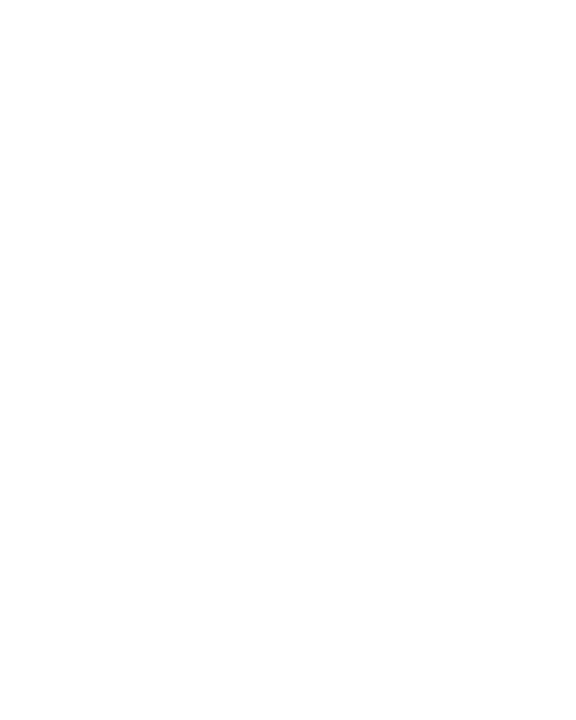

<IPython.core.display.Javascript object>


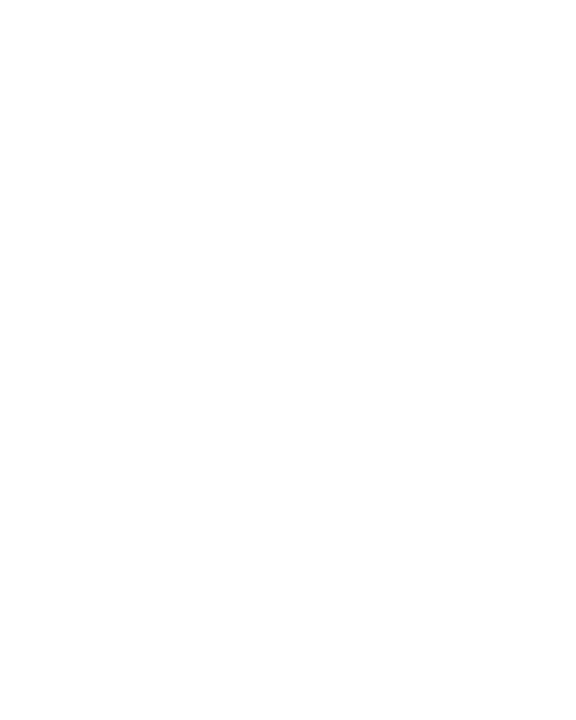

In [324]:
# 3 dimensions, Z = roi, x/y = pctl vs weight
clf_w = 1-np.arange(0,1.01, .01)
# make x/y/z, start with full clf and end with full regr
lin_ret_dict = {}
lin_def_dict = {}
# generate the scores
for w in clf_w:
    lin_ret_dict[w], lin_def_dict[w] = pctl_interp_score(test_scores, w, 'catboost_clf', 'catboost_regr_scl')
    
# some constants
desired_sROI = 1.05
desired_def = .1

lin_ret_df_3d = pd.DataFrame(lin_ret_dict)
lin_def_df_3d = pd.DataFrame(lin_def_dict)
x = lin_ret_df_3d.index.values+1
x = np.tile(x,(len(clf_w),1))
y = lin_ret_df_3d.columns.values
y = np.tile(y, (100, 1)).T
z_ret_scaled = lin_ret_df_3d.values.T
z_def_scaled = lin_def_df_3d.values.T
# plot
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(2,1,1,projection='3d')
ax.plot_surface(x, y, z_ret_scaled, cmap='viridis', edgecolor='none')
ax.plot_surface(x, y, np.ones(x.shape)*desired_sROI, alpha=.25)
ax.set_title('ROIs for percentiles of linearly combined classifier and regressor_scaled scores')
ax.set_xlabel('percentile of interpolated score')
ax.set_ylabel('linear classifier weight')
ax.set_zlabel('Simple ROI')
ax.set_ylim(-.02, 1.02)
ax.set_xlim(70, 102)

ax = fig.add_subplot(2,1,2, projection='3d')
ax.plot_surface(x, y, z_def_scaled, cmap='PiYG_r', edgecolor='none')
ax.plot_surface(x, y, np.ones(x.shape)*desired_def, alpha=.25)
ax.set_title('Default Rates for percentiles of linearly combined classifier and regressor_scaled scores')
ax.set_xlabel('percentile of interpolated score')
ax.set_ylabel('linear classifier weight')
ax.set_zlabel('Default Rate')
ax.set_ylim(-.02, 1.02)
ax.set_xlim(70, 102)
plt.show()

In [20]:
# Based on the above plots, I want to be somewhere in the lin_clf_w in [0, 0.4]
# and percentile of interpolated_score in [80, 100]
# Below, check differences between linear combination of clf with regr_scaled vs regr_unscaled

<IPython.core.display.Javascript object>


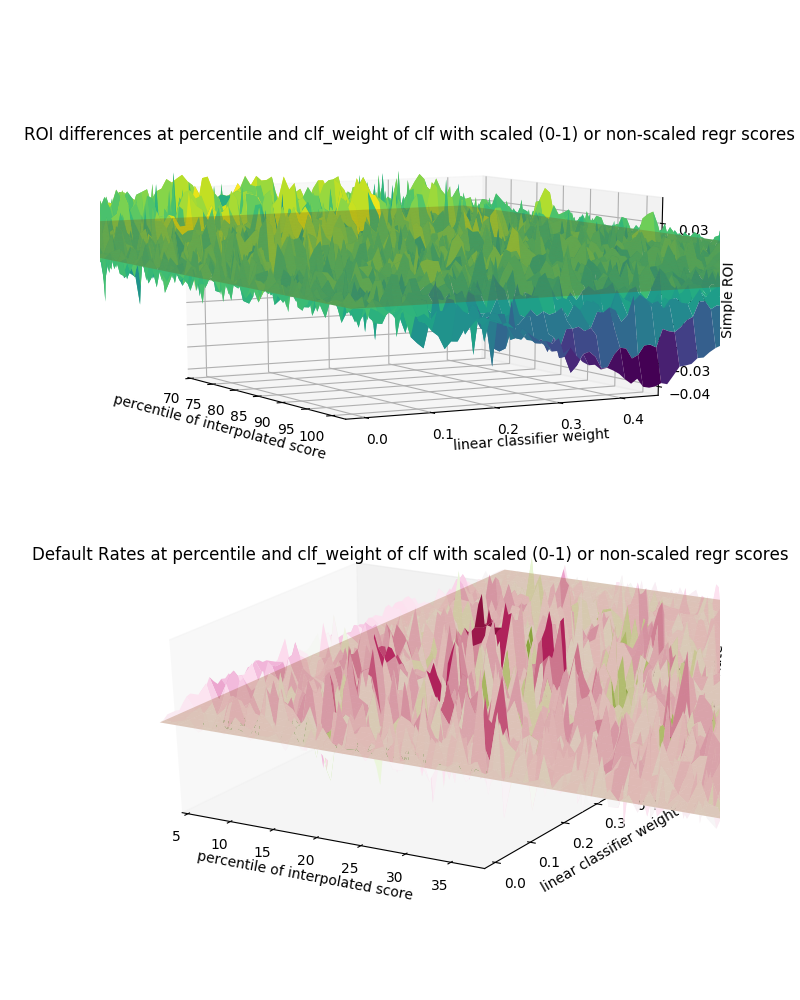

(70, 102)

In [21]:
x = lin_ret_df_3d.index.values+1
x = np.tile(x,(len(clf_w),1))
y = lin_ret_df_3d.columns.values
y = np.tile(y, (100, 1)).T
z_ret_diff = z_ret_scaled - z_ret_unscaled
z_def_diff = z_def_scaled - z_def_unscaled
# plot
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(2,1,1,projection='3d')
ax.plot_surface(x, y, z_ret_diff, cmap='viridis', edgecolor='none')
ax.plot_surface(x, y, np.zeros(x.shape), alpha=.25)
ax.set_title('ROI differences at percentile and clf_weight of clf with scaled (0-1) or non-scaled regr scores')
ax.set_xlabel('percentile of interpolated score')
ax.set_ylabel('linear classifier weight')
ax.set_zlabel('Simple ROI')
ax.set_ylim(-.02, .45)
ax.set_xlim(70, 102)

ax = fig.add_subplot(2,1,2, projection='3d')
ax.plot_surface(x, y, z_def_diff, cmap='PiYG_r', edgecolor='none')
ax.plot_surface(x, y, np.zeros(x.shape), alpha=.25)
ax.set_title('Default Rates at percentile and clf_weight of clf with scaled (0-1) or non-scaled regr scores')
ax.set_xlabel('percentile of interpolated score')
ax.set_ylabel('linear classifier weight')
ax.set_zlabel('Default Rate')
ax.set_ylim(-.02, .45)
ax.set_xlim(70, 102)

# bring in portfolio simulations based on above

In [57]:
# ps updated to use end_m distributions from paid and default from 
# test set. See portfolio_modeling jupyter notebook
from lendingclub.modeling import portfolio_simulating as ps

In [58]:
with open(os.path.join(config.data_dir, 'end_d_by_term_stat_grade.pkl'), 'rb') as f:
    end_d_by_term_stat_grade = pickle.load(f)

In [492]:
1 * .15 * (.75 * .15 + .25)

0.054375

In [59]:
# when how to determine what score-cutoff I want to use for investing, I need to determine what probability of picking a defaulting loan is acceptable. Plan is from each linearly combined percentile, find the probability of defaulting loan in that percentile, and then find the distribution of interest rates. Sample order should be Default or not first, and then depending on that, sample from the corresponding loan interest rate distribution. See below for example

In [60]:
l_stat_d = {'current': 'paid', 'late_120': 'charged_off', 'late_30': 'charged_off',
       'grace_15': 'paid', 'defaulted': 'charged_off'}
test_scores.loan_status = test_scores.loan_status.replace(l_stat_d)

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [222]:
# given pctl of (combined)-score, what does the rate distribution look like? Let's look at the regr
# key is (tials, starting_loans, score, pctl), value is tuple()
scores_modeling_d = {}
scores = ['pctl_clf', 'pctl_regr', 'pctl_both_rand']
trials = [1, 10, 100] #1000
starting_loans = [1, 20, 50, 100, 200, ] #250, 500, 2000, 1000
for trial in trials:
    for n_start in tqdm(starting_loans):
        for score in scores:
            for pctl in np.arange(70, 100):
                loans = test_scores.query('{0} >= @pctl'.format(score))
                res = []
                for t in range(trial):
                    res.append(ps.sim_portfolio(end_d_by_term_stat_grade, loans, n_inv_loans=n_start)[-1])
                scores_modeling_d[trial, n_start, score, pctl] = (np.mean(res), np.std(res))


In [223]:
means_d = {k: v[0] for k,v in scores_modeling_d.items()}
std_d = {k: v[1] for k,v in scores_modeling_d.items()}

In [236]:
mean_returns_df = pd.DataFrame(means_d, index=['mean_return']).T
std_returns_df = pd.DataFrame(std_d, index=['std_return']).T

In [250]:
# one time correction
# divisor = mean_returns_df.reset_index(level=0)['level_0']
# mean_returns_df['mean_return'] = mean_returns_df['mean_return']/divisor.values

In [ ]:
def plot_by_group(df, term, group_cols, target_col, size=(6,5), hist_alpha=.25):
    fig, ax = plt.subplots(figsize=size)
    df.loc[term,:].groupby(group_cols)[target_col].plot(kind='kde', alpha=1, ax=ax,)
    df.loc[term,:].groupby(group_cols)[target_col].plot(kind='hist', alpha=hist_alpha, density=True, ax=ax)
    ax.legend()
    plt.show()

In [ ]:
size = (6,5)
or trial in trials:
    for n_start in tqdm(starting_loans):
        for score in scores:
            for pctl in np.arange(70, 100):
                fig, ax = plt.subplots(figsize=size)
                mean_returns_df.loc[]

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  """


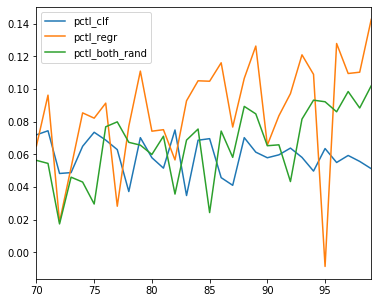

In [306]:
size = (6,5)
fig, ax = plt.subplots(figsize=size)
legend = []
for score in scores:
    mean_returns_df.loc[100,200,score].plot(ax=ax, legend=True)
    legend.append(score)
ax.legend(legend)
plt.show()

In [302]:
ex = mean_returns_df.loc[100,200].reset_index(level=0)
ex.columns=['score_type', 'mean_return']
ex

,score_type,mean_return
70,pctl_clf,0.071996
71,pctl_clf,0.074471
72,pctl_clf,0.048312
73,pctl_clf,0.048838
74,pctl_clf,0.064967
...,...,...
95,pctl_both_rand,0.092245
96,pctl_both_rand,0.086096
97,pctl_both_rand,0.098506
98,pctl_both_rand,0.088425


# use 100 trials and n_start of 200 loans, figure out what clf_wt to use
# from 0 to .2 clf_wt

In [338]:
clf_s = 'catboost_clf'
regr_s = 'catboost_regr_scl'
def pctl_greater_lin_wt_loans(df, clf_wt, pctl, clf_s, regr_s):
    df['comb_score_clf_wt_{0}'.format(clf_wt)] = clf_wt * df[clf_s] + (1-clf_wt)*df[regr_s]
    pctl_col = 'pctl_comb_score_clf_wt'#_{0}'.format(clf_wt)
    df[pctl_col] = pd.qcut(df['comb_score_clf_wt_{0}'.format(clf_wt)], 100, labels=False)
    return df.query("{0} >= @pctl".format(pctl_col))

In [340]:
pctl_greater_lin_wt_loans(test_scores, .1, .9, clf_s, regr_s)

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,end_d,issue_d,maturity_paid,maturity_time,maturity_time_stat_adj,maturity_paid_stat_adj,rem_to_be_paid,roi_simple,target_loose,target_strict,loan_status,id,grade,sub_grade,term,int_rate,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,catboost_both_score,catboost_both_rand,catboost_regr,catboost_clf,catboost_regr_scl,pctl_clf,pctl_regr,pctl_both_rand,months_recorded,comb_score_clf_wt_0.1,pctl_comb_score_clf_wt_0.1,catboost_interp_linear,pctl_ctb_interp_linear,pctl_comb_score_clf_wt_10.0,pctl_comb_score_clf_wt
8,2013-03-01,2010-03-01,1.000000,1.000000,1.0,1.0,0.000000,1.214850,0,0,paid,57245,C,C2,36,0.1311,0.127692,0.110950,0.094550,0.078486,0.062750,0.047333,0.032228,0.017427,0.002924,-0.011288,-0.025216,-0.038868,-0.052248,-0.065365,-0.078222,-0.090828,-0.103187,-0.115305,-0.127188,-0.138841,-0.150269,-0.161477,-0.172471,-0.183255,-0.193834,-0.204213,-0.214395,-0.224386,-0.234190,-0.243811,-0.253253,-999.000000,-9.449912,0.011794,0.883734,0.772265,69,89,41,36.0,0.783412,83,0.772265,83,83,83
13,2012-03-01,2010-02-01,1.000000,1.000000,1.0,1.0,0.000000,1.112901,0,0,paid,61390,A,A5,36,0.0788,0.039417,0.025492,0.011811,-0.001630,-0.014835,-0.027810,-0.040558,-0.053085,-0.065394,-0.077490,-0.089377,-0.101059,-0.112540,-0.123824,-0.134915,-0.145817,-0.156533,-0.167067,-0.177422,-0.187602,-0.197611,-0.207451,-0.217125,-0.226638,-0.235992,-0.245189,-0.254234,-0.263129,-0.271876,-0.280480,-0.288941,-0.005872,-0.005872,-0.005872,0.950671,0.759434,91,80,92,25.0,0.778558,78,0.759434,69,78,78
14,2013-03-01,2010-02-01,0.943687,1.000000,1.0,1.0,386.407623,1.156309,1,1,charged_off,61419,D,D2,36,0.1496,0.087672,0.073931,0.060432,0.047171,0.034143,0.021343,0.008766,-0.003592,-0.015736,-0.027670,-0.039399,-0.050927,-0.062257,-0.073395,-0.084343,-0.095105,-0.105686,-0.116089,-0.126317,-0.136374,-0.146264,-0.155990,-0.165554,-0.174961,-0.184213,-0.193313,-0.202265,-0.211071,-0.219734,-0.228257,-0.236642,-999.000000,-9.458562,0.002120,0.811907,0.765239,46,85,40,37.0,0.769906,66,0.765239,76,66,66
1446,2014-03-01,2011-05-01,1.000000,1.000000,1.0,1.0,0.000000,1.118505,0,0,paid,296737,A,A4,36,0.0749,0.041534,0.026176,0.011129,-0.003616,-0.018063,-0.032222,-0.046097,-0.059696,-0.073026,-0.086092,-0.098900,-0.111456,-0.123766,-0.135836,-0.147671,-0.159277,-0.170658,-0.181819,-0.192767,-0.203505,-0.214038,-0.224370,-0.234507,-0.244453,-0.254211,-0.263786,-0.273182,-0.282403,-0.291453,-0.300336,-0.309055,-0.007671,-0.007671,-0.007671,0.958454,0.758128,94,79,92,34.0,0.778160,77,0.758128,68,77,77
1894,2013-08-01,2010-07-01,1.000000,1.000000,1.0,1.0,0.000000,1.180725,0,0,paid,348340,B,B3,36,0.1112,0.097948,0.081616,0.065620,0.049951,0.034602,0.019565,0.004834,-0.009601,-0.023744,-0.037604,-0.051186,-0.064498,-0.077545,-0.090334,-0.102870,-0.115160,-0.127209,-0.139023,-0.150608,-0.161967,-0.173107,-0.184033,-0.194749,-0.205260,-0.215571,-0.225687,-0.235611,-0.245348,-0.254903,-0.264279,-0.273480,0.007962,0.007962,0.007962,0.916065,0.769482,80,87,96,37.0,0.784141,84,0.769482,80,84,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505614,2019-09-01,2019-06-01,0.000000,0.050000,1.0,1.0,29630.101562,0.000000,1,1,charged_off,154225423,B,B4,60,0.1240,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-999.000000,-9.599270,-0.085893,0.895779,0.701315,73,34,30,3.0,0.720761,25,0.701315,19,25,25
2505828,2019-07-01,2019-06-01,1.000000,0.083333,1.0,1.0,0.000000,1.016732,0,0,paid,154240497,B,B3,36,0.1171,0.013161,0

In [377]:
trials = 30
n_start = 100
res_d = {}
for clf_wt in tqdm(np.arange(0,.36,.01)):
    for pctl in np.arange(75,100):
        loans = pctl_greater_lin_wt_loans(test_scores, clf_wt, pctl, clf_s, regr_s)
        res = []
        for t in range(trial):
            res.append(ps.sim_portfolio(end_d_by_term_stat_grade, loans, n_inv_loans=n_start)[-1])
        res_d[clf_wt, pctl] = (np.mean(res), np.std(res))

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [392]:
means_d = {k: v[0] for k,v in res_d.items()}
std_d = {k: v[1] for k,v in res_d.items()}

In [404]:
means_df = pd.DataFrame(means_d, index=[0]).T
means_df = means_df.unstack().droplevel(0, axis=1)
std_df = pd.DataFrame(std_d, index=[0]).T
std_df = std_df.unstack().droplevel(0, axis=1)

In [406]:
x.shape

(101, 36)

In [407]:
y.shape

(25, 100)

In [413]:
means_df.shape

(36, 25)

In [408]:
means_df.index.values

array([0.000, 0.010, 0.020, 0.030, 0.040, 0.050, 0.060, 0.070, 0.080,
       0.090, 0.100, 0.110, 0.120, 0.130, 0.140, 0.150, 0.160, 0.170,
       0.180, 0.190, 0.200, 0.210, 0.220, 0.230, 0.240, 0.250, 0.260,
       0.270, 0.280, 0.290, 0.300, 0.310, 0.320, 0.330, 0.340, 0.350])

In [416]:
x.shape

(25, 36)

In [417]:
y.shape

(25, 36)

In [419]:
z_ret_unscaled.shape

(25, 36)

In [438]:
%matplotlib inline

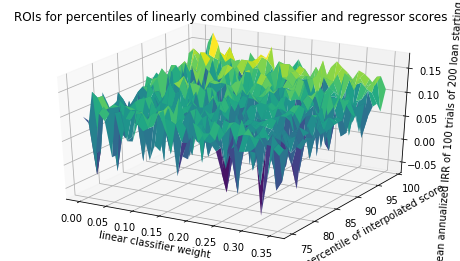

In [439]:
# # some constants
desired_sROI = 0
# desired_def = .1

x = means_df.index.values
y = means_df.columns.values
x = np.tile(x,(len(means_df.columns),1))
y = np.tile(y, (len(means_df.index), 1)).T
z = means_df.values.T
# z_def_unscaled = lin_def_df_3d.values.T
# plot
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(2,1,1,projection='3d')
ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')
# ax.plot_surface(x, y, np.ones(x.shape)*desired_sROI, alpha = .25)
ax.set_title('ROIs for percentiles of linearly combined classifier and regressor scores')
ax.set_xlabel('linear classifier weight')
ax.set_ylabel('percentile of interpolated score')
ax.set_zlabel('mean annualized IRR of 100 trials of 200 loan starting portfolios')
# ax.set_ylim(-.02, .45)
# ax.set_xlim(70, 102)

# ax = fig.add_subplot(2,1,2, projection='3d')
# ax.plot_surface(x, y, z_def_unscaled, cmap='PiYG_r', edgecolor='none')
# ax.plot_surface(x, y, np.ones(x.shape)*desired_def, alpha=.25)
# ax.set_title('Default Rates for percentiles of linearly combined classifier and regressor scores')
# ax.set_xlabel('percentile of interpolated score')
# ax.set_ylabel('linear classifier weight')
# ax.set_zlabel('Default Rate')
# ax.set_ylim(-.02, .45)
# ax.set_xlim(70, 102)
plt.show()

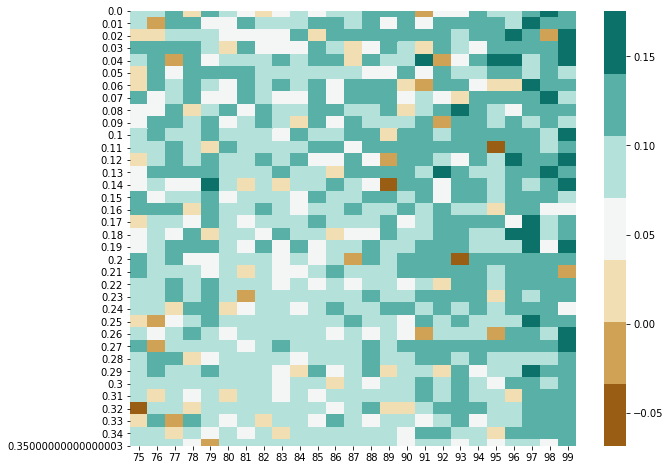

In [445]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(means_df, annot=False, cmap = sns.color_palette("BrBG", 7), ax=ax)
plt.show()

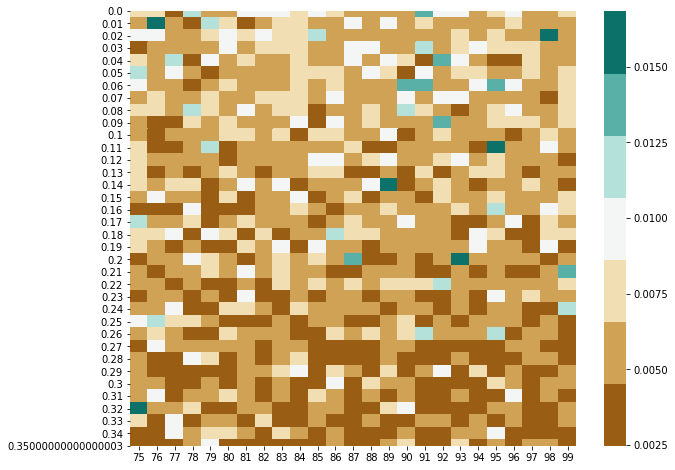

In [446]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(std_df, annot=False, cmap = sns.color_palette("BrBG", 7), ax=ax)
plt.show()

In [448]:
# use .29% clf weight, pick at 97 pctl and above, linear combination of clf_score and regr_score_scaled

In [476]:
ls ../../lendingclub/modeling

08_train.py  10_evaluate.py    models.py                __pycache__/
09_score.py  add_baselines.py  portfolio_simulating.py


In [490]:
%%writefile ../../lendingclub/modeling/score_utils.py
'''
Some utility functions for combining scores for catboost clf and regr
constants updated on 2019-12-09 21:30:04 
'''

min_comb_29_score = 0.8292615853334968 #this version based off test_scores only
# min_comb_29_score = 0.825562573351525 #this version based off all_scores

def scale_cb_regr_score(df):
    '''
    returns scaled score catboost_regr_scl. scaled to max/min of all historical
    predictions (all known loans, not just done, at time of model creation which as of 12.9.2019)
    is around 2.6 million loans.)
    '''
    cb_regr_min = -1.0514865667720885
    cb_regr_max = 0.3253468660329166
    return (df['catboost_regr'] - cb_regr_min)/(cb_regr_max - cb_regr_min)

def combined_score(clf_wt):
    '''
    returns a function that makes a linear combination of scores with passed
    clf_wt for the classifier
    '''
    def lin_comb_clf_regr(clf_score, regr_score, df):
        '''
        given colnames for clf and regr, makes a linear combination of 
        the scores
        '''
        return df[clf_score]*clf_wt + (1-clf_wt)*df[regr_score]
    return lin_comb_clf_regr

Overwriting ../../lendingclub/modeling/score_utils.py


In [486]:
test_scores['catboost_regr_scl'] = scale_cb_regr_score(test_scores)

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [487]:
clf_wt_29 = combined_score(.29)

In [488]:
comb_29 = clf_wt_29('catboost_clf', 'catboost_regr_scl', test_scores)
test_scores['comb_29'] = comb_29
test_scores['pctl_comb_29'] = pd.qcut(comb_29, 100, labels=False)

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [489]:
test_scores.query("pctl_comb_29 >= 97")['comb_29'].min()

0.8292615853334968

In [474]:
all_scores.query("pctl_comb_29 >= 97")['comb_29'].min()

0.825562573351525

In [463]:
# verify that scaling isn't changing the pctl
pd.qcut(all_scores['catboost_regr_scl'], 100, labels=False) == pd.qcut(all_scores['catboost_regr'], 100, labels=False)

2507335

# cutoff versions

In [28]:
def analyzer(clf_cutoff, eval_df, model, score_df, separate = False):
    score_name = 'catboost_both_'+ str(clf_cutoff)
    pctl_name = 'pctl_' + score_name
    if score_name not in eval_df:
        eval_df[score_name] = model.score(score_df,
                                                 random_penalty=True,
                                                 clf_cutoff=clf_cutoff)
    if pctl_name not in eval_df:
        eval_df[pctl_name] = pd.qcut(eval_df[score_name], 100, labels=False)
        
    picks = eval_df[eval_df['catboost_clf'] >= clf_cutoff]
    if not separate:
        def_mean = {}
        roi_mean = {}
        pctl_grouped = picks.groupby(pctl_name)
        for pctl, group in pctl_grouped:
            def_mean[pctl] = group['target_loose'].mean()
            roi_mean[pctl] = group['roi_simple'].mean()
        return pd.Series(def_mean), pd.Series(roi_mean)

    if separate:
        def_mean_regr = {}
        def_mean_clf = {}
        roi_mean_regr = {}
        roi_mean_clf = {}
        pctl_clf_grouped = picks.groupby('pctl_clf')
        pctl_regr_grouped = picks.groupby('pctl_regr')
        for pctl, group in pctl_clf_grouped:
            def_mean_clf[pctl] = group['target_loose'].mean()
            roi_mean_clf[pctl] = group['roi_simple'].mean()
        for pctl, group in pctl_regr_grouped:
            def_mean_regr[pctl] = group['target_loose'].mean()
            roi_mean_regr[pctl] = group['roi_simple'].mean()
        return pd.Series(def_mean_regr), pd.Series(def_mean_clf), \
            pd.Series(roi_mean_regr), pd.Series(roi_mean_clf)

In [29]:
# pick_regr_def, pick_clf_def, pick_regr_roi, pick_clf_roi = 

In [34]:
pick_def, pick_roi = analyzer(.95, test_scores, both, test_base_loan_info)
test_scores

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,end_d,issue_d,maturity_paid,maturity_time,maturity_time_stat_adj,maturity_paid_stat_adj,rem_to_be_paid,roi_simple,target_loose,target_strict,loan_status,id,grade,term,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,catboost_both_score,catboost_both_slow,catboost_regr,catboost_clf,pctl_clf,pctl_regr,catboost_both_rand,pctl_both_rand,catboost_both_0.85,pctl_catboost_both_0.85,catboost_both_0.95,pctl_catboost_both_0.95
34,2013-02-01,2010-02-01,1.000000,1.000000,1.00,1.000000,0.000000,1.113881,0,0,paid,68163,A,36,0.033749,0.018402,0.003370,-0.011355,-0.025780,-0.039912,-0.053759,-0.067325,-0.080620,-0.093647,-0.106415,-0.118929,-0.131194,-0.143217,-0.155003,-0.166558,-0.177887,-0.188996,-0.199888,-0.210570,-0.221045,-0.231320,-0.241398,-0.251283,-0.260980,-0.270494,-0.279828,-0.288987,-0.297974,-0.306793,-0.315448,-0.038681,-0.038681,-0.038681,0.928808,84,56,-0.038681,80,-0.038681,62,-9.404240,53
1485,2017-12-01,2014-12-01,1.000000,1.000000,1.00,1.000000,0.000000,1.102688,0,0,paid,300390,A,36,0.022443,0.007306,-0.007522,-0.022047,-0.036277,-0.050219,-0.063879,-0.077265,-0.090382,-0.103236,-0.115835,-0.128183,-0.140287,-0.152153,-0.163785,-0.175189,-0.186371,-0.197336,-0.208088,-0.218632,-0.228974,-0.239117,-0.249066,-0.258826,-0.268401,-0.277795,-0.287012,-0.296056,-0.304931,-0.313641,-0.322189,-0.010804,-0.010804,-0.010804,0.962797,95,77,-0.010804,91,-0.010804,77,-0.010804,95
3284,2012-06-01,2010-02-01,1.000000,1.000000,1.00,1.000000,0.000000,1.208045,0,0,paid,376257,C,36,0.124600,0.108844,0.093385,0.078214,0.063327,0.048718,0.034380,0.020307,0.006495,-0.007063,-0.020372,-0.033437,-0.046263,-0.058855,-0.071218,-0.083357,-0.095277,-0.106981,-0.118476,-0.129764,-0.140850,-0.151738,-0.162433,-0.172938,-0.183258,-0.193395,-0.203354,-0.213139,-0.222753,-0.232199,-0.241481,0.041089,0.041089,0.041089,0.900760,75,96,0.041089,99,0.041089,96,-9.495780,45
3340,2012-08-01,2010-01-01,1.000000,1.000000,1.00,1.000000,0.000000,1.240652,0,0,paid,377437,D,36,0.154114,0.137797,0.121791,0.106089,0.090685,0.075571,0.060742,0.046192,0.031914,0.017903,0.004153,-0.009341,-0.022586,-0.035585,-0.048346,-0.060872,-0.073169,-0.085241,-0.097093,-0.108730,-0.120156,-0.131377,-0.142395,-0.153215,-0.163842,-0.174279,-0.184531,-0.194601,-0.204492,-0.214210,-0.223757,-999.000000,-999.000000,-0.033222,0.754446,31,60,-9.288820,53,-9.255874,40,-9.883180,10
3398,2019-09-01,2014-12-01,0.930138,0.950000,0.95,0.930138,1599.687256,1.331127,0,1,current,378843,C,60,0.185697,0.159123,0.133369,0.108405,0.084204,0.060738,0.037982,0.015911,-0.005499,-0.026270,-0.046426,-0.065988,-0.084975,-0.103408,-0.121305,-0.138685,-0.155566,-0.171963,-0.187895,-0.203375,-0.218420,-0.233043,-0.247260,-0.261083,-0.274525,-0.287599,-0.300317,-0.312690,-0.324730,-0.336448,-0.347854,-999.000000,-999.000000,0.029626,0.773511,36,94,-9.908183,6,-9.548556,24,-9.310925,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506439,2019-07-01,2019-06-01,1.000000,0.083333,1.00,1.000000,0.000000,1.012598,0,0,paid,154289390,A,36,0.009303,0.008466,0.007631,0.006797,0.005964,0.005133,0.004303,0.003474,0.002647,0.001821,0.000996,0.000173,-0.000649,-0.001469,-0.002288,-0.003106,-0.003923,-0.004738,-0.005552,-0.006364,-0.007175,-0.007985,-0.008794,-0.009601,-0.010407,-0.011211,-0.012014,-0.012816,-0.013617,-0.014416,-0.015214,-0.040874,-0.040874,-0.040874,0.936228,87,55,-0.040874,80,-0.040874,62,-9.375372,56
2506447,2019-07-01,2019-06-01,1.000000,0.083333,1.00,1.000000,0.000000,1.000900,0,0,paid,154290216,B,36,-0.001958,-0.002786,-0.003612,-0.004437,-0.005260,-0.006082,-0.006903,-0.007722,-0.008540,-0.009357,-0.010172,-0.010986,-0.011799,-0.012610,-0.013420,-0.014229,-0.015036,-0.015843,-0.016647,-0.017451,-0.018253,-0.019053,-0

In [35]:
pick_roi

90    0.992909
91    1.031072
92    1.055688
93    1.058325
94    1.058689
95    1.066126
96    1.067149
97    1.074216
98    1.077077
99    1.103835
dtype: float64

In [36]:
pick_def

90    0.059701
91    0.049759
92    0.023256
93    0.030498
94    0.035313
95    0.030473
96    0.032905
97    0.024860
98    0.034510
99    0.024058
dtype: float64

In [32]:
pick_roi

55    0.961388
56    0.985532
57    0.996008
58    1.010975
59    1.026911
60    1.027732
61    1.017448
62    1.029209
63    1.033900
64    1.046598
65    1.039774
66    1.050404
67    1.057003
68    1.051956
69    1.058808
70    1.063149
71    1.062673
72    1.064092
73    1.064420
74    1.058493
75    1.066432
76    1.065242
77    1.076878
78    1.075598
79    1.074667
80    1.070707
81    1.080273
82    1.080524
83    1.083606
84    1.084679
85    1.088860
86    1.080857
87    1.097786
88    1.102776
89    1.106824
90    1.103951
91    1.112451
92    1.108436
93    1.111855
94    1.132874
95    1.123909
96    1.135803
97    1.140826
98    1.164603
99    1.208023
dtype: float64

In [31]:
pick_def

55    0.121415
56    0.108260
57    0.108347
58    0.098637
59    0.087480
60    0.091419
61    0.104334
62    0.093098
63    0.089816
64    0.079454
65    0.093023
66    0.077047
67    0.071429
68    0.078589
69    0.071429
70    0.063352
71    0.073836
72    0.073034
73    0.072173
74    0.077047
75    0.072173
76    0.078652
77    0.060995
78    0.064956
79    0.073836
80    0.079391
81    0.073836
82    0.078589
83    0.082665
84    0.081862
85    0.075381
86    0.085875
87    0.078589
88    0.079454
89    0.082665
90    0.084202
91    0.080257
92    0.101043
93    0.102729
94    0.077849
95    0.098637
96    0.098716
97    0.096231
98    0.092295
99    0.106656
dtype: float64

In [21]:
%debug

> /home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/pandas/core/internals/construction.py(612)sanitize_index()
    610 
    611     if len(data) != len(index):
--> 612         raise ValueError("Length of values does not match length of index")
    613 
    614     if isinstance(data, ABCIndexClass) and not copy:

ipdb> len(data)
2507335
ipdb> len(index)
124642
ipdb> q


In [17]:
test_scores[plot_cols]

,roi_simple,grade,loan_status,0.07,catboost_both_score,catboost_regr,catboost_clf,pctl_clf,pctl_regr,catboost_both_slow
34,1.113881,A,paid,0.003370,-0.038681,-0.038681,0.928808,84,56,-0.038681
1485,1.102688,A,paid,-0.007522,-0.010804,-0.010804,0.962797,95,77,-0.010804
3284,1.208045,C,paid,0.093385,0.041089,0.041089,0.900760,75,96,0.041089
3340,1.240652,D,paid,0.121791,-999.000000,-0.033222,0.754446,31,60,-9.580911
3398,1.331127,C,current,0.133369,-999.000000,0.029626,0.773511,36,94,-9.241625
...,...,...,...,...,...,...,...,...,...,...
2506439,1.012598,A,paid,0.007631,-0.040874,-0.040874,0.936228,87,55,-0.040874
2506447,1.000900,B,paid,-0.003612,-0.041019,-0.041019,0.926450,83,55,-0.041019
2506801,1.016671,C,paid,0.012734,-999.000000,-0.177224,0.726222,26,12,-9.104120
2507237,1.000000,A,paid,-0.004964,-0.030300,-0.030300,0.948159,91,62,-0.030300


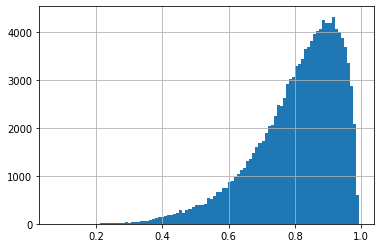

In [13]:
test_scores['catboost_clf'].hist(bins=100)

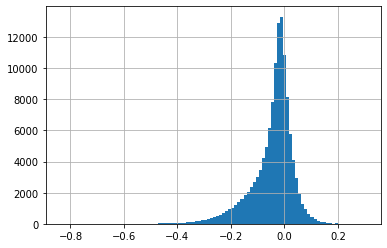

In [14]:
test_scores['catboost_regr'].hist(bins=100)

In [29]:
test_scores[plot_cols]

,roi_simple,grade,loan_status,0.07,catboost_both_score,catboost_regr,catboost_clf,pctl_clf,pctl_regr
34,1.113881,A,paid,0.003370,-0.038681,-0.038681,0.928808,84,56
1485,1.102688,A,paid,-0.007522,-0.010804,-0.010804,0.962797,95,77
3284,1.208045,C,paid,0.093385,0.041089,0.041089,0.900760,75,96
3340,1.240652,D,paid,0.121791,-999.000000,-0.033222,0.754446,31,60
3398,1.331127,C,current,0.133369,-999.000000,0.029626,0.773511,36,94
...,...,...,...,...,...,...,...,...,...
2506439,1.012598,A,paid,0.007631,-0.040874,-0.040874,0.936228,87,55
2506447,1.000900,B,paid,-0.003612,-0.041019,-0.041019,0.926450,83,55
2506801,1.016671,C,paid,0.012734,-999.000000,-0.177224,0.726222,26,12
2507237,1.000000,A,paid,-0.004964,-0.030300,-0.030300,0.948159,91,62


No handles with labels found to put in legend.


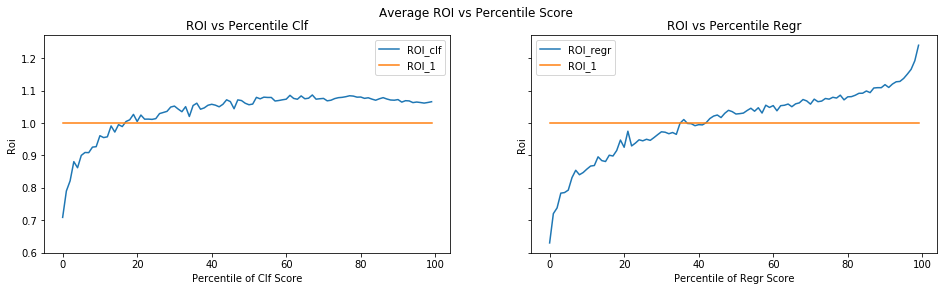

In [11]:
fig, axs = plt.subplots(1,2 , figsize=(16,4), sharex=True, sharey=True)
axs[0].plot(clf_pctl_roi, )
axs[0].plot(clf_pctl_roi.index, [1] * len(clf_pctl_roi), label = 'roi 1')
plt.legend()
axs[1].plot(regr_pctl_roi, )
axs[1].plot(regr_pctl_roi.index, [1] * len(regr_pctl_roi), label = 'roi 1')
fig.suptitle('Average ROI vs Percentile Score')
axs[0].set_title('ROI vs Percentile Clf')
axs[0].set_xlabel('Percentile of Clf Score')
axs[0].set_ylabel('Roi')
axs[1].set_xlabel('Percentile of Regr Score')
axs[1].set_ylabel('Roi')
axs[1].set_title('ROI vs Percentile Regr')
axs[1].legend(['ROI_regr','ROI_1'])
axs[0].legend(['ROI_clf','ROI_1'])

<IPython.core.display.Javascript object>


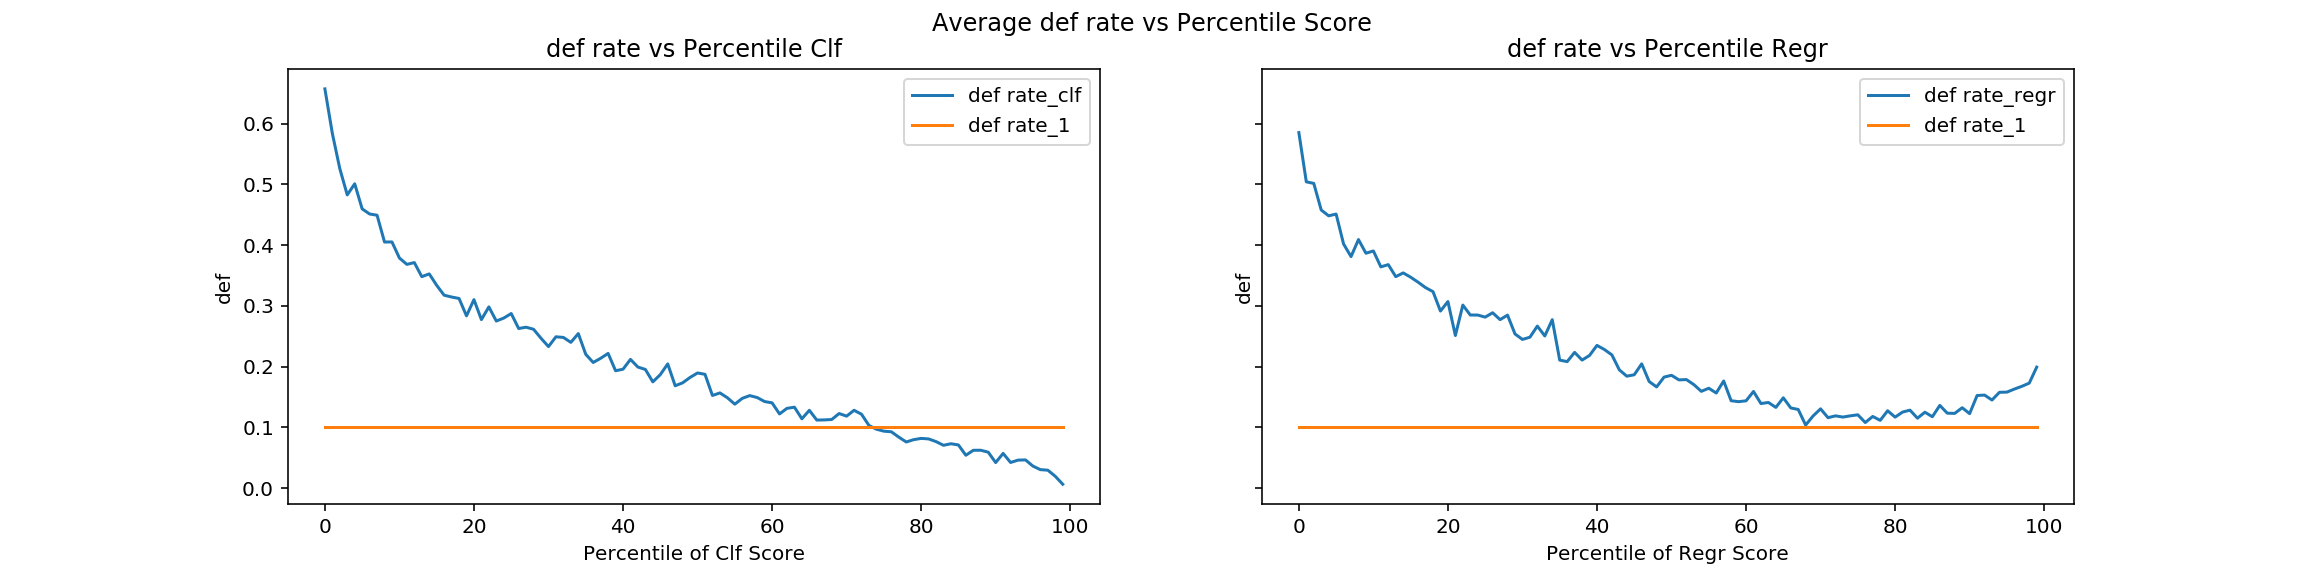

No handles with labels found to put in legend.


In [27]:
fig, axs = plt.subplots(1,2 , figsize=(16,4), sharex=True, sharey=True)
axs[0].plot(clf_pctl_def, )
axs[0].plot(clf_pctl_def.index, [.1] * len(clf_pctl_def), label = 'def .1')
plt.legend()
axs[1].plot(regr_pctl_def, )
axs[1].plot(regr_pctl_def.index, [.1] * len(regr_pctl_def), label = 'def .1')
fig.suptitle('Average def rate vs Percentile Score')
axs[0].set_title('def rate vs Percentile Clf')
axs[0].set_xlabel('Percentile of Clf Score')
axs[0].set_ylabel('def')
axs[1].set_xlabel('Percentile of Regr Score')
axs[1].set_ylabel('def')
axs[1].set_title('def rate vs Percentile Regr')
axs[1].legend(['def rate_regr','def rate_1'])
axs[0].legend(['def rate_clf','def rate_1'])

In [24]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [25]:
subset = test_scores.sample(n=100)

<IPython.core.display.Javascript object>


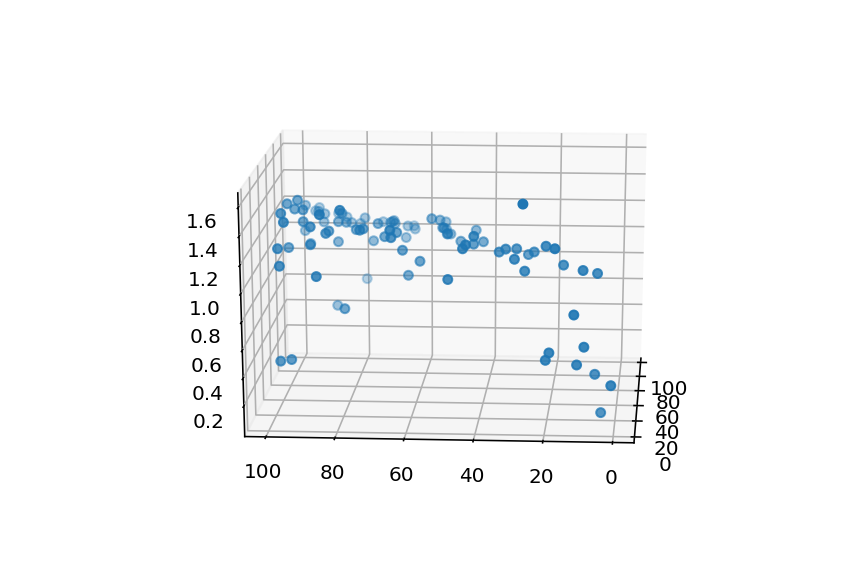

In [26]:
ax = plt.axes(projection='3d')

z = subset['roi_simple']
x = subset['pctl_clf']
y = subset['pctl_regr']
ax.scatter3D(x,y,z);

# some analysis of old portfolios

In [28]:
# pre_justin_RF, n_loans , invested $ amt
n_loans = 3171
invested = 90849.90
ongoing_loans = 451 + 1 + 7 + 10 
ongoing_pr = 3325.28
adj_pr = 3210.98
pmt_to_date = 93860.31
ret_to_date = pmt_to_date/invested
print('{0}$ invested in {1} loans, of which {2} are ongoing with princp amt {3}'.format(invested, n_loans, ongoing_loans, ongoing_pr))
print('{0} return to date from {1} payments to date'.format(ret_to_date, pmt_to_date))
print('combining pmts to date with adj_prncp_val = {0}'.format((pmt_to_date + adj_pr)/invested))
print('this was original portfolio')

90849.9$ invested in 3171 loans, of which 469 are ongoing with princp amt 3325.28
1.0331360849048816 return to date from 93860.31 payments to date
combining pmts to date with adj_prncp_val = 1.0684798772480761
this was original portfolio


In [33]:
# 0.2.1_rf, n_loans , invested $ amt
n_loans = 37
invested = 2300
ongoing_loans = 18
ongoing_pr = 363.31
adj_pr = 363.31
pmt_to_date = 2121.80
ret_to_date = pmt_to_date/invested
print('{0}$ invested in {1} loans, of which {2} are ongoing with princp amt {3}'.format(invested, n_loans, ongoing_loans, ongoing_pr))
print('{0} return to date from {1} payments to date'.format(ret_to_date, pmt_to_date))
print('combining pmts to date with adj_prncp_val = {0}'.format((pmt_to_date + adj_pr)/invested))
print('only random forest')

2300$ invested in 37 loans, of which 18 are ongoing with princp amt 363.31
0.9225217391304349 return to date from 2121.8 payments to date
combining pmts to date with adj_prncp_val = 1.0804826086956523
only random forest


In [35]:
# 1.0.0, n_loans , invested $ amt
n_loans = 66
invested = 5650
ongoing_loans = 34 + 1 + 1
ongoing_pr = 1206.54
adj_pr = 1189.15
pmt_to_date = 4723.93
ret_to_date = pmt_to_date/invested
print('{0}$ invested in {1} loans, of which {2} are ongoing with princp amt {3}'.format(invested, n_loans, ongoing_loans, ongoing_pr))
print('{0} return to date from {1} payments to date'.format(ret_to_date, pmt_to_date))
print('combining pmts to date with adj_prncp_val = {0}'.format((pmt_to_date + adj_pr)/invested))
print('fastai feed forward NN')

5650$ invested in 66 loans, of which 36 are ongoing with princp amt 1206.54
0.8360938053097345 return to date from 4723.93 payments to date
combining pmts to date with adj_prncp_val = 1.046562831858407
fastai feed forward NN


In [36]:
# 2.0.0, n_loans , invested $ amt
n_loans = 354
invested = 8850
ongoing_loans = 185 + 1 + 4 + 6
ongoing_pr = 2097.83
adj_pr = 2005.46
pmt_to_date = 7356.98
ret_to_date = pmt_to_date/invested
print('{0}$ invested in {1} loans, of which {2} are ongoing with princp amt {3}'.format(invested, n_loans, ongoing_loans, ongoing_pr))
print('{0} return to date from {1} payments to date'.format(ret_to_date, pmt_to_date))
print('combining pmts to date with adj_prncp_val = {0}'.format((pmt_to_date + adj_pr)/invested))
print('first ensemble of RF and fastai feed forward NN')

8850$ invested in 354 loans, of which 196 are ongoing with princp amt 2097.83
0.8312971751412429 return to date from 7356.98 payments to date
combining pmts to date with adj_prncp_val = 1.057902824858757
fastai feed forward NN


In [38]:
# 3.0.0, n_loans , invested $ amt
n_loans = 591
invested = 22350
ongoing_loans = 375 + 1 + 3 
ongoing_pr = 8456.44
adj_pr = 8377.36
pmt_to_date = 15526.75
ret_to_date = pmt_to_date/invested
print('{0}$ invested in {1} loans, of which {2} are ongoing with princp amt {3}'.format(invested, n_loans, ongoing_loans, ongoing_pr))
print('{0} return to date from {1} payments to date'.format(ret_to_date, pmt_to_date))
print('combining pmts to date with adj_prncp_val = {0}'.format((pmt_to_date + adj_pr)/invested))
print('second ensemble of RF and fastai feed forward NN with embeddings')

22350$ invested in 591 loans, of which 379 are ongoing with princp amt 8456.44
0.6947091722595078 return to date from 15526.75 payments to date
combining pmts to date with adj_prncp_val = 1.0695351230425056
second ensemble of RF and fastai feed forward NN with embeddings
